In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import cm as cmaps
from pylab import rcParams
import healpy as hp
from tqdm import *
from astropy import units as u
from scipy.ndimage.filters import gaussian_filter

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from plot_params import params
from simulation.astrometry_sim import QuasarSim
from theory.units import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
pylab.rcParams.update(params)
plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/Draft/plots/"
data_dir = "/Users/smsharma/QuasarSims/"

## Figure 1: induced velocity and acceleration maps

Simulate a subhalo sample and compute lens-induced velocities and accelerations.

In [3]:
max_sep = 20
nside = 128
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True, 
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=True, 
                do_alpha=True,
                sh_profile='Gaussian')

sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1e10 * M_s, N_calib=150, alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

Simulating 1193 subhalos between 7.0 and 10.0


In [78]:
sim.analysis_pipeline()

# np.save("../../data/mu_qsrs", sim.mu_qsrs)
# np.save("../../data/alpha_qsrs", sim.alpha_qsrs)

In [6]:
sim.mu_qsrs = np.load("../data/mu_qsrs.npy")
sim.alpha_qsrs = np.load("../data/alpha_qsrs.npy")

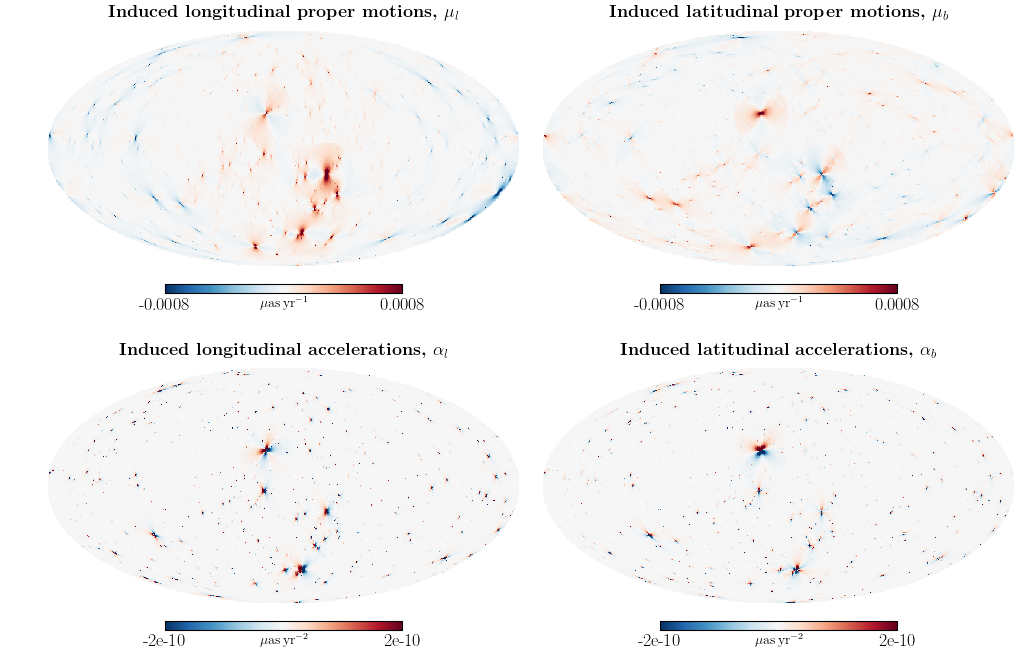

In [10]:
max_mu = 8e-4
max_alpha = 2e-10

cmap = cmaps.RdBu_r
cmap.set_under('w')

fig = plt.gcf()
fig.set_size_inches(1.1 * 12.5, 1.1 * 8.5)


hp.mollview(1e6 * sim.mu_qsrs[:,0],max=max_mu, min=-max_mu, title=r"\bf{Induced longitudinal proper motions}, $\mu_l$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, sub=(2,2,1))
hp.mollview(1e6 * sim.mu_qsrs[:,1],max=max_mu, min=-max_mu, title=r"\bf{Induced latitudinal proper motions}, $\mu_b$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, sub=(2,2,2))
hp.mollview(1e6 * sim.alpha_qsrs[:,0],max=max_alpha, min=-max_alpha, title=r"\bf{Induced longitudinal accelerations}, $\alpha_l$", unit='$\mu$as\,yr$^{-2}$', cmap=cmap, sub=(2,2,3))
hp.mollview(1e6 * sim.alpha_qsrs[:,1],max=max_alpha, min=-max_alpha, title=r"\bf{Induced latitudinal accelerations}, $\alpha_b$", unit='$\mu$as\,yr$^{-2}$', cmap=cmap, sub=(2,2,4))

plt.savefig(plots_dir + "/maps_mu_alpha.pdf")

## Figure 12: azimuthal asymmetry

Analyze cluster runs to get azimuthal asymmetry over $m$-modes.

In [4]:
nsim = 500
nside = 128
lmax = 3 * nside - 1
lmin_plot = 10
lmax_plot = 200

In [5]:
fB_ary = np.zeros((lmax, lmax))
for i in tqdm_notebook(range(nsim)):
    fB = np.load(data_dir + "/gaussian_nside128_sep20_mc" + str(i) + ".npz")['fB']
    fB_ary += np.abs(fB*1e6)**2
fB_ary /= nsim

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [6]:
fC_ary = np.zeros((lmax, lmax))
for i in tqdm_notebook(range(nsim)):
    fC = np.load(data_dir + "/gaussian_nside128_sep20_mc" + str(i) + ".npz")['fC']
    fC_ary += np.abs(fC*1e6)**2
fC_ary /= nsim

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [7]:
fB_ary_compressed = (fB_ary)[lmin_plot:lmax_plot,lmin_plot:lmax_plot]
fC_ary_compressed = (fC_ary)[lmin_plot:lmax_plot,lmin_plot:lmax_plot]

In [8]:
av_ary = np.zeros_like(fB_ary_compressed)
for l in range(len(av_ary)):
    thing = np.where(fB_ary_compressed[l, :]!=0,fB_ary_compressed[l, :],np.nan)
    av_ary[l, :l] = ((thing - np.nanmean(thing)) / np.nanmean(thing))[:l]
# plt.plot((thing - np.nanmean(thing)) / thing)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


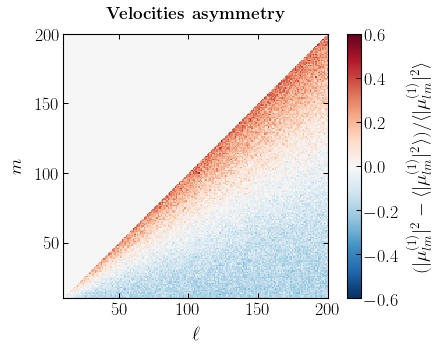

In [37]:
plt.figure(figsize=(8 / 1.2, 6 / 1.2))

plt.imshow(np.transpose(gaussian_filter(av_ary, 0)), 
           origin='lower', vmin=-0.6, vmax=0.6,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
           cmap='RdBu_r'
          )

cbar = plt.colorbar(label=r"$(|\mu_{lm}^{(1)}|^2 - \langle|\mu_{lm}^{(1)}|^2\rangle) / \langle|\mu_{lm}^{(1)}|^2\rangle$")

plt.ylabel("$m$")
plt.xlabel("$\ell$")

plt.title('\\textbf{Velocities asymmetry}', fontsize=17, y=1.02)

plt.tight_layout()
plt.savefig(plots_dir + "m_asymm_1.pdf")

In [32]:
fB_alpha_ary = np.zeros((lmax, lmax))
for i in tqdm_notebook(range(nsim)):
    fB_alpha = np.load(data_dir + "/gaussian_nside128_sep20_mc" + str(i) + ".npz")['fB_alpha']
    fB_alpha_ary += np.abs(fB_alpha*1e6)**2
fB_alpha_ary /= nsim

In [33]:
fB_alpha_ary_compressed = (fB_alpha_ary)[lmin_plot:lmax_plot,lmin_plot:lmax_plot]

In [34]:
av_alpha_ary = np.zeros_like(fB_alpha_ary_compressed)
for l in range(len(av_alpha_ary)):
    thing = np.where(fB_alpha_ary_compressed[l, :]!=0,fB_alpha_ary_compressed[l, :],np.nan)
    av_alpha_ary[l, :l] = ((thing - np.nanmean(thing)) / np.nanmean(thing))[:l]
# plt.plot((thing - np.nanmean(thing)) / thing)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


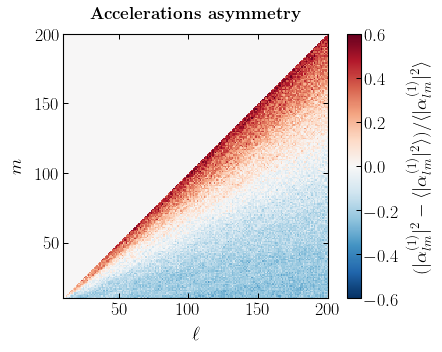

In [39]:
plt.figure(figsize=(8 / 1.2, 6 / 1.2))

plt.imshow(np.transpose(gaussian_filter(av_alpha_ary, 0)), 
           origin='lower', vmin=-0.6, vmax=0.6,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
#            cmap=palettable.cmocean.sequential.Ice_20_r.get_mpl_colormap(),
           cmap='RdBu_r'
          )

cbar = plt.colorbar(label=r"$(|\alpha_{lm}^{(1)}|^2 - \langle|\alpha_{lm}^{(1)}|^2\rangle) / \langle|\alpha_{lm}^{(1)}|^2\rangle$")

plt.ylabel("$m$")
plt.xlabel("$\ell$")

plt.title('\\textbf{Accelerations asymmetry}', fontsize=17, y=1.02)

plt.tight_layout()
plt.savefig(plots_dir + "m_asymm_alpha_1.pdf")

## Figure xx: absolute velocities

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


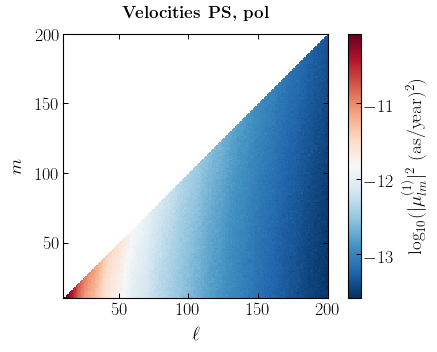

In [12]:
plt.figure(figsize=(8 / 1.2, 6 / 1.2))

plt.imshow(np.transpose(gaussian_filter(np.log10(fB_ary_compressed), 0)), 
           origin='lower',
#            vmin=-16, vmax=-10,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
           cmap='RdBu_r'
          )

cbar = plt.colorbar(label=r"$\log_{10}(|\mu_{lm}^{(1)}|^2$ (as/year)$^2)$")

plt.ylabel("$m$")
plt.xlabel("$\ell$")

plt.title('\\textbf{Velocities PS, pol}', fontsize=17, y=1.02)

plt.tight_layout()
# plt.savefig(plots_dir + "m_asymm_1.pdf")

## Testing with kvt

In [48]:
max_sep = 20
nside = 1024
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True, 
                sim_uniform=False, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='Gaussian',
                f_sub=1.,
                R0=.1 * pc)

sim.set_mass_distribution(sim.rho_M_SI, M_min=1e10 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1e10 * M_s, N_calib=150, alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_NFW, R_min=1e-3 * kpc, R_max=260 * kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

Simulating 117 subhalos between 10.0 and 10.0


In [49]:
sim.analysis_pipeline()

Size set to 0.1 pc


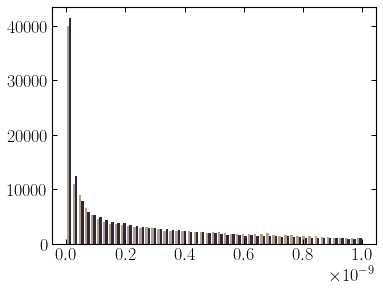

In [50]:
plt.hist(sim.mu_qsrs, bins=np.linspace(0,0.000000001));

In [61]:
for imc in range(10):
    np.save("../data/mu_qsrs_1e10Ms_100pc/mu_qsrs_" + str(imc), np.transpose(np.load("/Users/smsharma/QuasarSims/gaussian_M1e10_R1e2_nside128_sep20_mc" + str(imc) + ".npz")['mu_qsrs']))
    
    

In [60]:
len(np.load("../data/mu_qsrs_1e10Ms_100pc/mu_qsrs_5.npy"))

555934

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


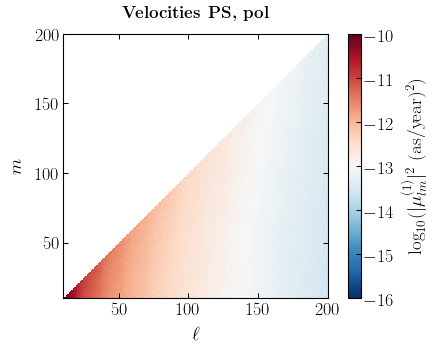

In [34]:
plt.figure(figsize=(8 / 1.2, 6 / 1.2))

plt.imshow(np.transpose(gaussian_filter(np.log10(fB_ary_compressed), 0)), 
           origin='lower',
           vmin=-16, vmax=-10,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
           cmap='RdBu_r'
          )

cbar = plt.colorbar(label=r"$\log_{10}(|\mu_{lm}^{(1)}|^2$ (as/year)$^2)$")

plt.ylabel("$m$")
plt.xlabel("$\ell$")

plt.title('\\textbf{Velocities PS, pol}', fontsize=17, y=1.02)

plt.tight_layout()
# plt.savefig(plots_dir + "m_asymm_1.pdf")

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


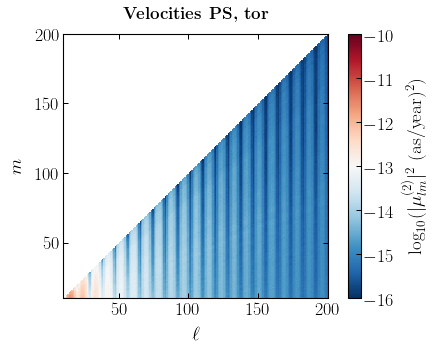

In [35]:
plt.figure(figsize=(8 / 1.2, 6 / 1.2))

plt.imshow(np.transpose(gaussian_filter(np.log10(fC_ary_compressed), 0)), 
           origin='lower',
           vmin=-16, vmax=-10,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
           cmap='RdBu_r'
          )

cbar = plt.colorbar(label=r"$\log_{10}(|\mu_{lm}^{(2)}|^2$ (as/year)$^2)$")

plt.ylabel("$m$")
plt.xlabel("$\ell$")

plt.title('\\textbf{Velocities PS, tor}', fontsize=17, y=1.02)

plt.tight_layout()
# plt.savefig(plots_dir + "m_asymm_1.pdf")

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


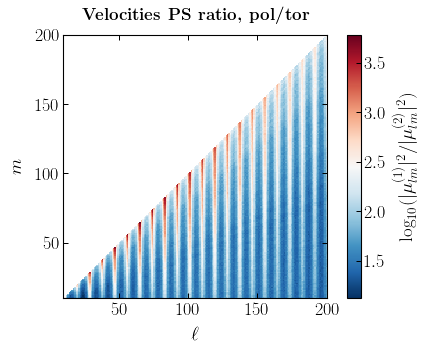

In [36]:
plt.figure(figsize=(8 / 1.2, 6 / 1.2))

plt.imshow(np.log10(np.transpose(gaussian_filter((fB_ary_compressed), 0))/np.transpose(gaussian_filter((fC_ary_compressed), 0))), 
           origin='lower',
#            vmin=-16, vmax=-10,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
           cmap='RdBu_r'
          )

cbar = plt.colorbar(label=r"$\log_{10}(|\mu_{lm}^{(1)}|^2 / |\mu_{lm}^{(2)}|^2)$")

plt.ylabel("$m$")
plt.xlabel("$\ell$")

plt.title('\\textbf{Velocities PS ratio, pol/tor}', fontsize=17, y=1.02)

plt.tight_layout()
# plt.savefig(plots_dir + "m_asymm_1.pdf")

In [ ]:
# fB_ary = np.zeros((lmax, lmax))
for i in tqdm_notebook(range(nsim)):
    fB = np.load(data_dir + "/gaussian_nside128_sep20_mc" + str(i) + ".npz")['mu_qsrs']
    fB_ary += np.abs(fB*1e6)**2
fB_ary /= nsim

In [39]:
np.shape(np.load(data_dir + "/gaussian_nside128_sep20_mc" + str(1) + ".npz")['mu_qsrs'])

(2, 196608)

In [7]:
for imc in range(5):
    np.save("../data/mu_qsrs_uniform/mu_qsrs_" + str(imc), np.transpose(np.load(data_dir + "/gaussian_uniform_f0p2_M1e8_R1e2_nside128_sep20_mc" + str(imc) + ".npz")['mu_qsrs']))

for imc in range(5):
    np.save("../data/mu_qsrs_quasarsDR2/mu_qsrs_" + str(imc), np.transpose(np.load(data_dir + "/gaussian_quasarsDR2_f0p2_M1e8_R1e2_nside128_sep20_mc" + str(imc) + ".npz")['mu_qsrs']))

